# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os 
import tensorflow as tf
import csv
import numpy as np
from PIL import Image
import pandas as pd

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

Using TensorFlow backend.


### Change directory

In [0]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Labs')

### Load the training data from train.csv file

In [25]:

with open('train_labels.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    print(row)


['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
['raccoon-17.jpg', '259', '194', 'raccoon', '95', '60', '167', '118']
['raccoon-11.jpg', '660', '432', 'raccoon', '3', '1', '461', '431']
['raccoon-63.jpg', '600', '400', 'raccoon', '74', '107', '280', '290']
['raccoon-63.jpg', '600', '400', 'raccoon', '227', '93', '403', '298']
['raccoon-60.jpg', '273', '185', 'raccoon', '58', '33', '197', '127']
['raccoon-69.jpg', '205', '246', 'raccoon', '12', '11', '188', '240']
['raccoon-180.jpg', '600', '400', 'raccoon', '119', '21', '368', '399']
['raccoon-200.jpg', '261', '193', 'raccoon', '107', '10', '249', '166']
['raccoon-141.jpg', '249', '202', 'raccoon', '1', '1', '154', '176']
['raccoon-19.jpg', '259', '194', 'raccoon', '87', '8', '182', '89']
['raccoon-84.jpg', '303', '166', 'raccoon', '31', '6', '197', '163']
['raccoon-124.jpg', '259', '194', 'raccoon', '17', '39', '239', '147']
['raccoon-182.jpg', '500', '500', 'raccoon', '17', '122', '279', '499']
['raccoon-111.

### Print the shape of the train dataset

In [29]:
train_df = pd.read_csv('train_labels.csv')
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


In [30]:
train_df.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128 

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
# Install the tool for unrar the rar file.
!pip install patool

In [0]:
# First get the images from archive data

import patoolib
patoolib.extract_archive("images_racoon.rar", outdir="/content/drive/My Drive/Colab Notebooks/Labs")

In [40]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


In [0]:
# Loading the csv file and getting the individual variables values
with open('train_labels.csv', 'r') as csvfile:
    paths = []  
    coords = np.zeros((sum(1 for line in csvfile)-1, 4))    
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(reader)
    for col, row in enumerate(reader):
           
        path,  image_width,image_height,_, x0, y0, x1, y1 = row  
        #print(path)
        #print(row)
        path = "/content/drive/My Drive/Colab Notebooks/Labs/images/"+path
        coords[col, 0] = int(x0) * IMAGE_SIZE / int(image_width) # Normalize bounding box by image size
        coords[col, 1] = int(y0) * IMAGE_SIZE / int(image_height) # Normalize bounding box by image size
        coords[col, 2] = (int(x1)- int(x0)) * IMAGE_SIZE / int(image_width) # Normalize bounding box by image size
        coords[col, 3] = (int(y1) - int(y0)) * IMAGE_SIZE / int(image_height)
        paths.append(path)

In [65]:
# Just for checking
print(coords.shape)
print(paths)
print(image_height)

(173, 4)
['/content/drive/My Drive/Colab Notebooks/Labs/images/raccoon-17.jpg', '/content/drive/My Drive/Colab Notebooks/Labs/images/raccoon-11.jpg', '/content/drive/My Drive/Colab Notebooks/Labs/images/raccoon-63.jpg', '/content/drive/My Drive/Colab Notebooks/Labs/images/raccoon-63.jpg', '/content/drive/My Drive/Colab Notebooks/Labs/images/raccoon-60.jpg', '/content/drive/My Drive/Colab Notebooks/Labs/images/raccoon-69.jpg', '/content/drive/My Drive/Colab Notebooks/Labs/images/raccoon-180.jpg', '/content/drive/My Drive/Colab Notebooks/Labs/images/raccoon-200.jpg', '/content/drive/My Drive/Colab Notebooks/Labs/images/raccoon-141.jpg', '/content/drive/My Drive/Colab Notebooks/Labs/images/raccoon-19.jpg', '/content/drive/My Drive/Colab Notebooks/Labs/images/raccoon-84.jpg', '/content/drive/My Drive/Colab Notebooks/Labs/images/raccoon-124.jpg', '/content/drive/My Drive/Colab Notebooks/Labs/images/raccoon-182.jpg', '/content/drive/My Drive/Colab Notebooks/Labs/images/raccoon-111.jpg', '/co

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [67]:
ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

EPOCHS = 10 # Number of epochs. I got decent performance with just 5.
BATCH_SIZE = 32 # Depends on your GPU or CPU RAM.

model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)












17227776/17225924 [==============================] - 1s 0us/step


In [68]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
gt = coords
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [72]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

#checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
#                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
#stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
#reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

model.fit(batch_images,gt,
            epochs=30,batch_size = 32,
            verbose=1)



Epoch 1/30
173/173 [==============================] - 8s 46ms/step - loss: 2783.7782 - IoU: 0.0937
Epoch 2/30
173/173 [==============================] - 0s 517us/step - loss: 667.0259 - IoU: 0.4368
Epoch 3/30
173/173 [==============================] - 0s 496us/step - loss: 644.1832 - IoU: 0.5365
Epoch 4/30
173/173 [==============================] - 0s 498us/step - loss: 546.2977 - IoU: 0.5399
Epoch 5/30
173/173 [==============================] - 0s 524us/step - loss: 348.8700 - IoU: 0.5902
Epoch 6/30
173/173 [==============================] - 0s 497us/step - loss: 270.3356 - IoU: 0.5777
Epoch 7/30
173/173 [==============================] - 0s 503us/step - loss: 247.8495 - IoU: 0.6159
Epoch 8/30
173/173 [==============================] - 0s 502us/step - loss: 194.6591 - IoU: 0.6550
Epoch 9/30
173/173 [==============================] - 0s 491us/step - loss: 167.8069 - IoU: 0.6975
Epoch 10/30
173/173 [==============================] - 0s 504us/step - loss: 146.8834 - IoU: 0.7104
Epoch 1

### Pick a test image from the given data

In [0]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
import cv2
filename = '/content/drive/My Drive/Colab Notebooks/Labs/images/raccoon-92.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

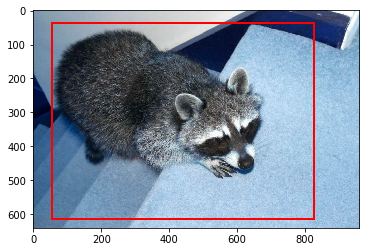

In [81]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Change your present working directory

In [0]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Labs')

### Load your data file

In [97]:
df = pd.read_csv('daily-minimum-temperatures-in-me.csv')
df.sort_index(inplace=True)
df.head()

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


#### Plot data

In [0]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.utils import np_utils

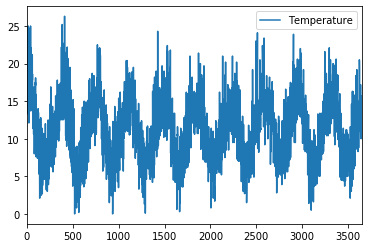

In [99]:
df.plot()

#### Descibe your dataframe

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
Date           3650 non-null object
Temperature    3650 non-null float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [101]:
df.head()
# Dataframe contains only 2 columns, date and Temperature

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


#### Check for null values

In [102]:
#Check for null values
df.isnull().sum()

Date           0
Temperature    0
dtype: int64

#### Drop null values

In [0]:
# No null values in the dataframe

#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b65163400>]],
      dtype=object)

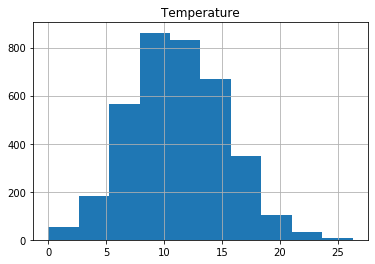

In [104]:
# Display the data using historgram. 
df.hist()

In [0]:
# There are very few values containing temperature 20 to 25.

#### Check the maximum and minimum values

In [105]:
#Check Data Range and Maximum and minimum values
print('Min', np.min(df))
print('Max', np.max(df))

Min Date           1981-01-01
Temperature             0
dtype: object
Max Date           1990-12-31
Temperature          26.3
dtype: object


### Normalize the data

In [0]:
df.drop("Date", axis=1, inplace=True)

In [0]:
# Normalize the data using min max scaler
#Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

#### Check the maximum and minimum values of scaled data

In [111]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


#### Look into some of the scaled values

In [114]:
scaled[0:5]

array([[0.78707224],
       [0.68060837],
       [0.7148289 ],
       [0.55513308],
       [0.60076046]])

### Split data into Training and Testing

In [0]:
#70% examples will used for training (in the begining)
train_size = int(len(scaled) * 0.70)

#30% will be used for Test
test_size = len(scaled - train_size)

#### Print train and test size

In [116]:
#Split the data
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
#window - how long the sequence will be
def create_dataset(dataset, window=1):
    
    dataX, dataY = [], []
    
    for i in range(len(dataset)-window):
        
        a = dataset[i:(i+window), 0]        
        dataX.append(a)
        dataY.append(dataset[i + window, 0])
    
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [0]:
#Create Input and Output
window_size = 1
X_train, y_train = create_dataset(train, window_size)
X_test, y_test = create_dataset(test, window_size)

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [120]:
X_train.shape

(2554, 1)

In [123]:
y_train.shape

(X_train.shape[0], X_train.shape[1], 1)

(2554, 1, 1)

In [124]:
#Make it 3 Dimensional Data - needed for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2554, 1, 1)
(1094, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [0]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32, input_shape=(window_size, 1)))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mse'])

### Summarize your model

In [142]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [143]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

Train on 2554 samples, validate on 1094 samples
Epoch 1/100
2554/2554 [==============================] - 1s 334us/sample - loss: 0.1019 - mean_squared_error: 0.1019 - val_loss: 0.0349 - val_mean_squared_error: 0.0349
Epoch 2/100
2554/2554 [==============================] - 0s 155us/sample - loss: 0.0173 - mean_squared_error: 0.0173 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 3/100
2554/2554 [==============================] - 0s 161us/sample - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 4/100
2554/2554 [==============================] - 0s 162us/sample - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 5/100
2554/2554 [==============================] - 0s 169us/sample - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 6/100
2554/2554 [==============================] - 0s 192us/sample - loss: 0.0117 - mean_squared_erro

## Make Predictions and Evaluate your model

In [144]:
loss_and_metrics = model.evaluate(X_train, y_train)
print(loss_and_metrics)
loss_and_metrics = model.evaluate(X_test, y_test)
print(loss_and_metrics)

2554/2554 [==============================] - 0s 75us/sample - loss: 0.0099 - mean_squared_error: 0.0099
[0.009941597668251305, 0.0099415975]
1094/1094 [==============================] - 0s 72us/sample - loss: 0.0087 - mean_squared_error: 0.0087
[0.008675231253115335, 0.008675232]


In [0]:
#Get prediction for both Training and Test Data
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

## Plot the results

In [0]:
#Un-normalize the predited data
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

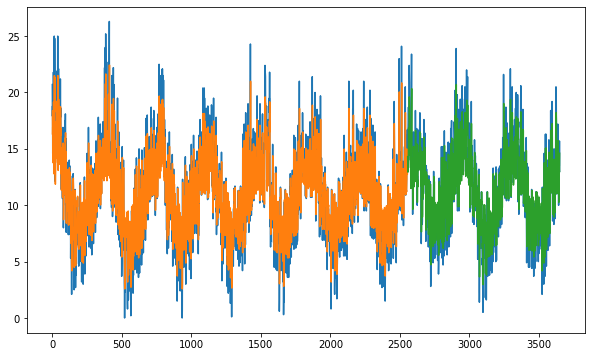

In [147]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size:len(trainPredict)+window_size, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window_size*2):len(scaled), :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

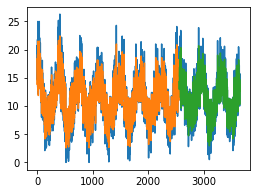

In [148]:
plt.figure(figsize=(4,3))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()